In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
%matplotlib inline

In [3]:
sns.set()

In [56]:
name = 'ross'
date = datetime(2019,3,17)
filename = '{}_{}.pkl'.format(name,date.strftime('%d%b%y'))
filename

'ross_17Mar19.pkl'

In [57]:
data = pd.read_pickle('processed_data/'+filename)


FileNotFoundError: [Errno 2] No such file or directory: 'processed_data/ross_17Mar19.pkl'

In [36]:
data.reset_index(drop=True,inplace=True)

In [37]:
data.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt,Lat_Rad,Lon_Rad,Lat_Delta,Lon_Delta,Lat_Rad_Delta,Lon_Rad_Delta,GPS_Alt_Delta,distance,gradient,grad_colour
0,03/18/2019,08:19:35,45.092109,6.062207,1788.8,81776.195,1771.848,21.14,4.318,0.787006,0.105805,0.000023,0.000011,3.984587e-07,1.890192e-07,NaN,2.677995,NaN,2
1,03/18/2019,08:19:36,45.092086,6.062196,1786.4,81772.875,1772.177,21.14,4.325,0.787005,0.105805,0.000006,0.000001,1.106539e-07,2.042035e-08,-2.4,0.711157,-16.505362,2
2,03/18/2019,08:19:37,45.092080,6.062195,1786.6,81772.688,1772.196,21.14,4.325,0.787005,0.105805,0.000019,-0.000009,3.316126e-07,-1.513200e-07,0.2,2.220320,84.852854,0
3,03/18/2019,08:19:39,45.092061,6.062204,1785.6,81776.625,1771.806,21.16,4.325,0.787005,0.105805,0.000014,0.000035,2.471386e-07,6.078982e-07,-1.0,3.156107,-72.419403,2
4,03/18/2019,08:19:40,45.092047,6.062169,1784.7,81775.141,1771.953,21.15,4.331,0.787005,0.105805,-0.000016,-0.000024,-2.733186e-07,-4.216715e-07,-0.9,2.575519,-70.738331,2


In [38]:
data['gps_alt_roll']=data.GPS_Alt.rolling(400).mean()

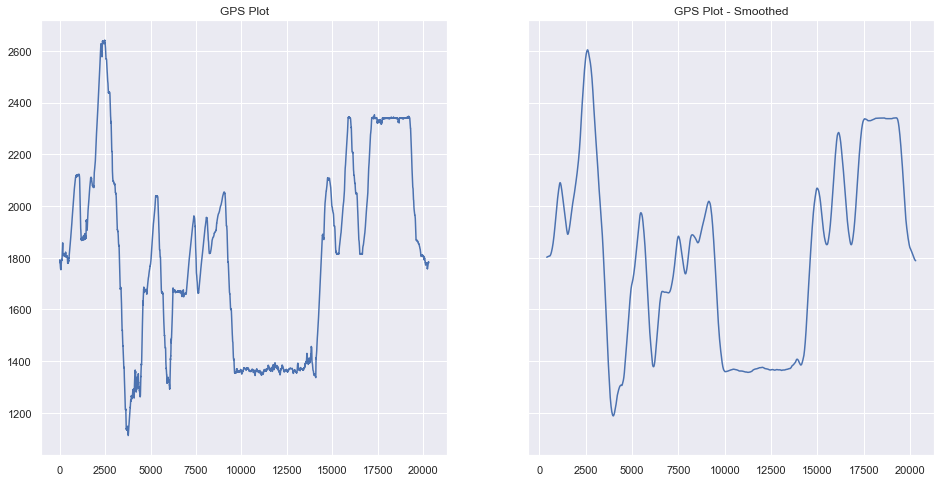

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.GPS_Alt.plot(ax=ax1,title='GPS Plot')
data.gps_alt_roll.plot(ax=ax2,title='GPS Plot - Smoothed')


In [40]:
data['gps_alt_roll_delta'] = data.gps_alt_roll[:-1] - data.gps_alt_roll[1:].values
data['gps_alt_raw_delta'] = data.GPS_Alt[:-1] - data.GPS_Alt[1:].values

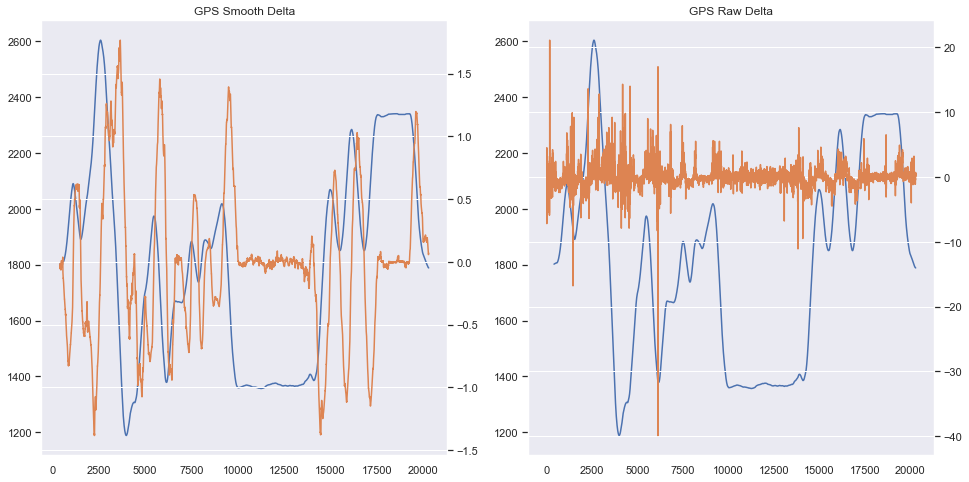

In [41]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta')
data.gps_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta')
data.gps_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

In [42]:
#data['gps_alt_roll_delta_roll_delta'] = data.gps_alt_roll_delta_roll[:-1] - data.gps_alt_roll_delta_roll[1:].values
#data['gps_alt_roll_delta_roll_delta_roll'] =data.gps_alt_roll_delta_roll_delta.rolling(240).mean()

#data['gps_alt_raw_delta_roll_delta'] = data.gps_alt_raw_delta_roll[:-1] - data.gps_alt_raw_delta_roll[1:].values
#data['gps_alt_raw_delta_roll_delta_roll'] =data.gps_alt_raw_delta_roll_delta.rolling(240).mean()

data['gps_alt_raw_delta_roll'] =data.gps_alt_raw_delta.rolling(180).mean()
data['gps_alt_roll_delta_roll'] =data.gps_alt_roll_delta.rolling(180).mean()

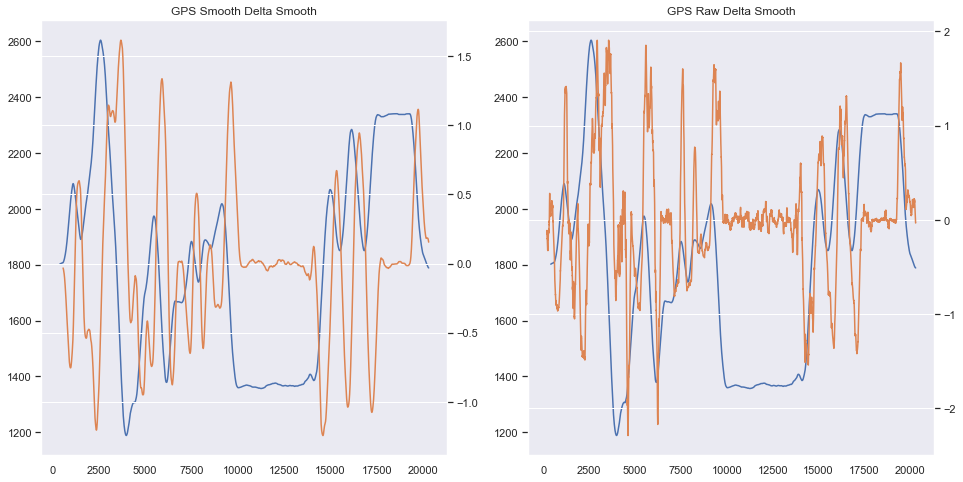

In [43]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta Smooth')
data.gps_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta Smooth')
data.gps_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

In [44]:
signs = np.sign(data.gps_alt_raw_delta_roll.fillna(0))
signchange = ((np.roll(signs, 1) - signs) != 0).astype(int)

In [45]:
sign_changes_idx = signchange.index[signchange == 1].tolist()

In [46]:
routes_list=[]
for i in range(len(sign_changes_idx)-1):
    #print(sign_changes_idx[i],sign_changes_idx[i+1]-1, signs[sign_changes_idx[i]])
    start = sign_changes_idx[i]
    end = sign_changes_idx[i+1]-1
    sign = signs[sign_changes_idx[i]]
    max_val = np.max(data.loc[start:end,('gps_alt_raw_delta_roll')])
    routes_list.append((start,end,sign,max_val ))
    
routes = pd.DataFrame(routes_list,columns=['start_idx','end_idx','sign','peak'])
routes.head()

,start_idx,end_idx,sign,peak
0,179,319,-1.0,-0.012778
1,320,517,1.0,0.280556
2,518,1080,-1.0,-0.000556
3,1081,1352,1.0,1.415556
4,1353,1835,-1.0,-0.001667


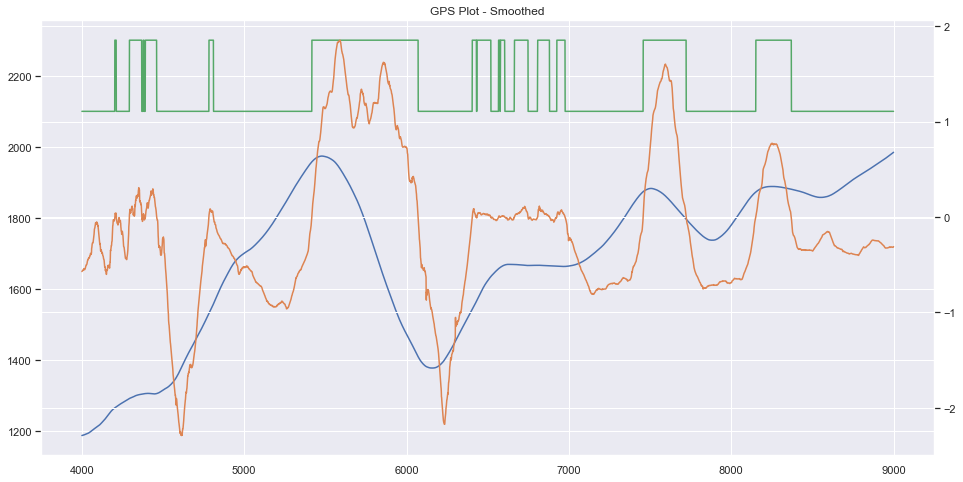

In [47]:
small_data =data.loc[4000:9000]
small_signs = signs.loc[4000:9000] *100 +2200
fig, ax= plt.subplots(1, 1, figsize=(16,8))
small_data.gps_alt_roll.plot(ax=ax,title='GPS Plot - Smoothed')
small_data.gps_alt_raw_delta_roll.plot(ax=ax,secondary_y=True)
small_signs.plot(ax=ax)

In [48]:
peak_filter = 0.5
runs = routes[(routes.sign== 1) & (routes.peak >= peak_filter)].copy()
runs.reset_index(inplace=True)
num_runs = runs.shape[0]
num_runs

10

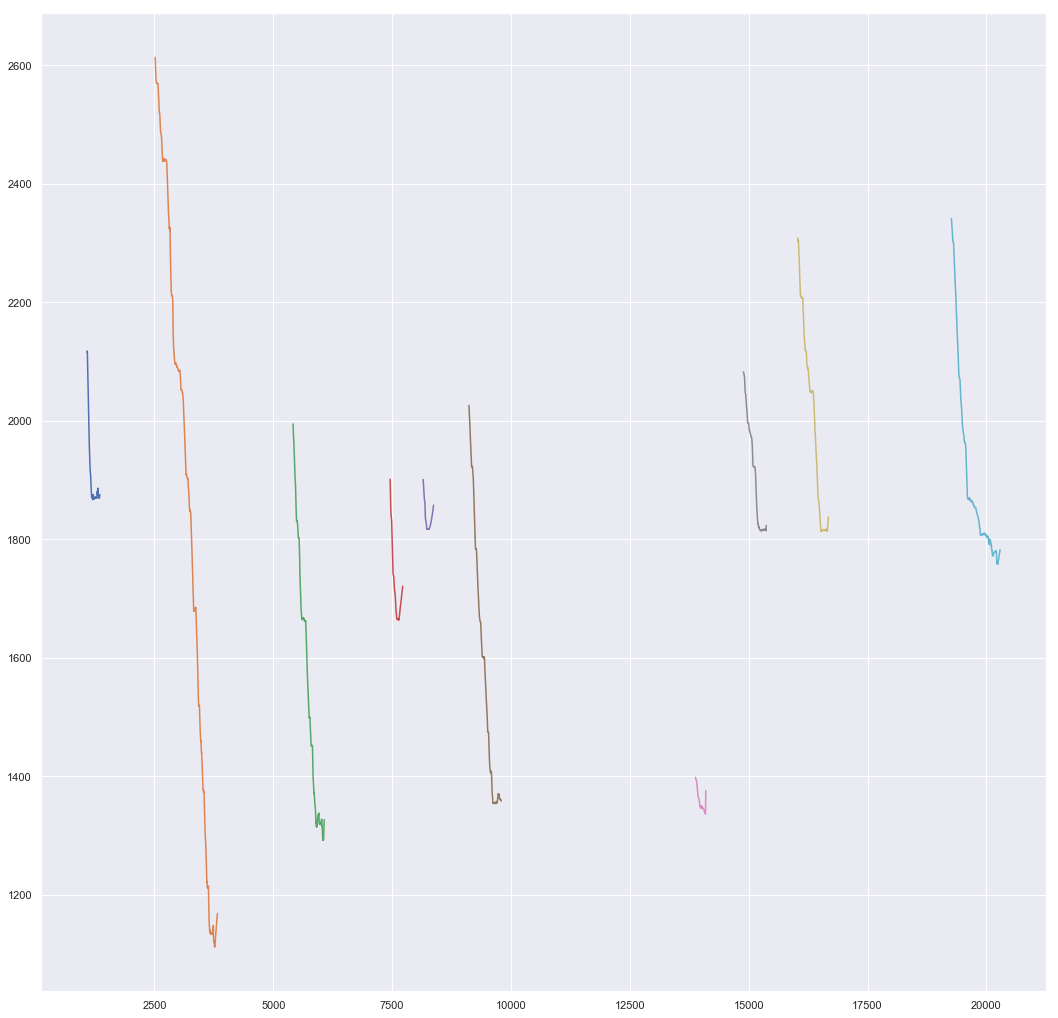

In [49]:
fig, axes= plt.subplots(1,1, figsize=(18,18))
#axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes)

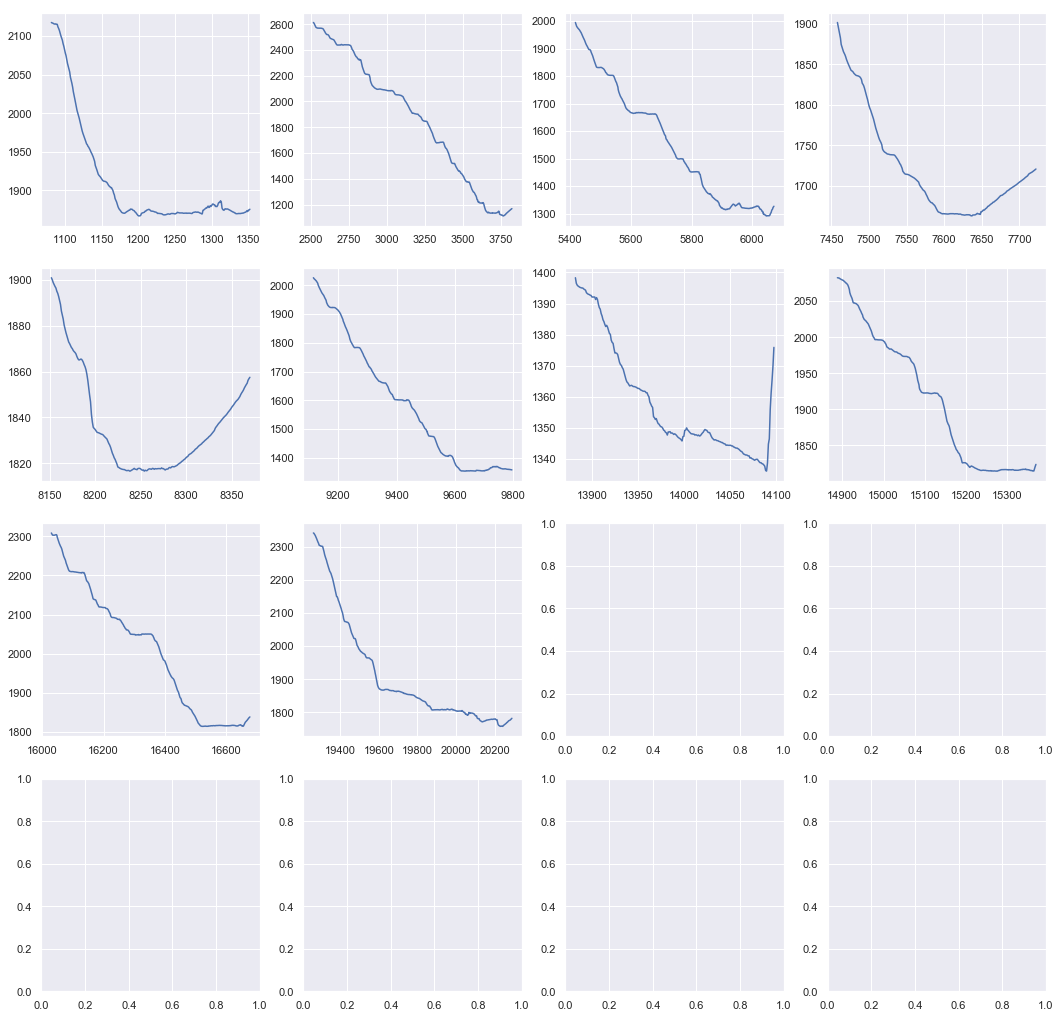

In [50]:
fig, axes= plt.subplots(4, 4, figsize=(18,18))
axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes[i])

In [51]:
import gpxpy.gpx

In [52]:
def save_gpx_run(data, runs, name, date):
    
    gpx = gpxpy.gpx.GPX()
    # Create first track in our GPX:
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    
    num_runs = runs.shape[0]
    
    for i in range(num_runs):
        print(i)
        gpx_segment = gpxpy.gpx.GPXTrackSegment()
        gpx_track.segments.append(gpx_segment)
        
        start  =np.int(runs.loc[i].start_idx)
        end =  np.int(runs.loc[i].end_idx)
        #print(start, end)
        run_data = data.loc[start:end].copy()
        
        points = run_data[['Lat','Lon','GPS_Alt']].values

        #create points
        for point in points:
            gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(point[0],point[1], elevation=point[2]))
    
    xml = gpx.to_xml()
    
    #filename = '{}_{}_{}.xml'.format(name,date.strftime('%d%b%y'),i)
    filename = '{}_{}_runs.xml'.format(name,date.strftime('%d%b%y'))
    print(filename)
    with open('gpx_files/'+filename,'w') as f:
        f.write(xml)

In [53]:
save_gpx_run(data,runs,name, date)

0
1
2
3
4
5
6
7
8
9
giacomo_18Mar19_runs.xml


In [58]:
def normalise_run(values):
    diff = values.max() - values.min()
    values = (values -  values.min() )/diff
    return values

In [59]:
def save_json_run(data, runs, name, date):
    
    num_runs = runs.shape[0]
    
    for i in range(num_runs):
        print(i)
        
        start  =np.int(runs.loc[i].start_idx)
        end =  np.int(runs.loc[i].end_idx)
        run_data = data.loc[start:end].copy()
        
        values=run_data[['Lat','Lon','GPS_Alt']].copy()
        values.rename(columns={'Lat':'y','Lon':'x','GPS_Alt':'z'},inplace=True)
    
        values = normalise_run(values)
        json_values = values.to_dict(orient='records')
    
        filename = '{}_{}_{}.json'.format(name,date.strftime('%d%b%y'),i)
        print(filename)
        with open('json_files/'+filename,'w') as f:
            json.dump(json_values,f)
        

In [60]:
save_json_run(data,runs,name, date)

0
ross_17Mar19_0.json
1
ross_17Mar19_1.json
2
ross_17Mar19_2.json
3
ross_17Mar19_3.json
4
ross_17Mar19_4.json
5
ross_17Mar19_5.json
6
ross_17Mar19_6.json
7
ross_17Mar19_7.json
8
ross_17Mar19_8.json
9
ross_17Mar19_9.json
